<a href="https://colab.research.google.com/github/duchung2604/hung/blob/main/TH4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [2]:
import pandas as pd
from google.colab import drive

# Kết nối Google Drive
drive.mount('/content/drive')


file_path = '/content/drive/My Drive/10GB/heart_rate.csv'

df = pd.read_csv(file_path)


Mounted at /content/drive


# TIEN XU LY

In [3]:
# Hiển thị 5 dòng đầu để kiểm tra
print(df.head())

        T1       T2       T3       T4
0  84.2697  91.4634  60.4839  59.2885
1  84.2697  91.4634  60.4839  59.2885
2  84.0619  91.1834  60.4606  59.2885
3  85.6542  91.8788  60.3391  58.8973
4  87.2093  91.1772  60.0762  58.4359


In [5]:
# Đổi tên cột cho dễ sử dụng nếu cần
# Assuming the dataframe has 4 columns and you want to rename all of them
# You need to provide a list with 4 names
df.columns = ['timestamp', 'heart_rate_T1', 'heart_rate_T2', 'heart_rate_T3']

In [6]:
# Chuyển đổi cột timestamp về dạng datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [7]:
# Sắp xếp dữ liệu theo thời gian (nếu chưa sắp xếp)
df = df.sort_values('timestamp')

In [8]:
# Kiểm tra dữ liệu thiếu hoặc ngoại lai
print("\nKiểm tra giá trị thiếu:")
print(df.isnull().sum())


Kiểm tra giá trị thiếu:
timestamp          0
heart_rate_T1      0
heart_rate_T2    850
heart_rate_T3    909
dtype: int64


In [10]:
# Loại bỏ giá trị thiếu (nếu có)
# df = df.dropna(subset=['heart_rate']) # Lỗi xảy ra ở đây vì cột 'heart_rate' không tồn tại sau khi đổi tên.
# Thay đổi để kiểm tra giá trị thiếu trong các cột 'heart_rate_T1', 'heart_rate_T2', 'heart_rate_T3'
df = df.dropna(subset=['heart_rate_T1', 'heart_rate_T2', 'heart_rate_T3'])

In [12]:
# Kiểm tra khoảng giá trị nhịp tim
print("\nThông tin dữ liệu nhịp tim:")
# print(df['heart_rate'].describe()) # Lỗi xảy ra ở đây vì cột 'heart_rate' không tồn tại sau khi đổi tên.
# Thay đổi để kiểm tra thông tin mô tả cho các cột nhịp tim đã đổi tên
print(df[['heart_rate_T1', 'heart_rate_T2', 'heart_rate_T3']].describe())


Thông tin dữ liệu nhịp tim:
       heart_rate_T1  heart_rate_T2  heart_rate_T3
count     891.000000     891.000000     891.000000
mean       96.908537      58.869506      58.515133
std         5.852166       3.416485       3.484603
min        80.213900      52.083300      52.915300
25%        92.633700      56.804850      56.345300
50%        98.940400      58.604800      57.731600
75%       101.483000      60.313850      59.845300
max       104.895000      75.473300      77.424400


In [14]:
# Lọc giá trị bất thường (nhịp tim ngoài khoảng sinh lý)
# Nhịp tim bình thường thường từ 40-180 bpm, ngoài ra có thể xem xét loại bỏ
# Áp dụng điều kiện lọc cho từng cột nhịp tim
df = df[
    (df['heart_rate_T1'] >= 40) & (df['heart_rate_T1'] <= 180) &
    (df['heart_rate_T2'] >= 40) & (df['heart_rate_T2'] <= 180) &
    (df['heart_rate_T3'] >= 40) & (df['heart_rate_T3'] <= 180)
]

# PHAN TICH PHO TAN SO

In [25]:
import pandas as pd
import numpy as np
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

# Kiểm tra tên cột và định dạng timestamp
print(df.head())
print(df.columns)


# Kiem tra neu timestamp chua la index thi dat lam index
if 'timestamp' in df.columns:
    df = df.set_index('timestamp')
elif not isinstance(df.index, pd.DatetimeIndex):
     # Neu timestamp khong phai cot va index khong phai datetime, co the la loi logic
     print("Loi: Cot 'timestamp' khong ton tai hoac index khong phai DatetimeIndex")
     # Ban can xu ly loi nay tuy theo truong hop cu the
     pass # Tiep tuc chay de xem loi cu the hon neu can


# Chạy phân tích phổ
# **CHON COT NHIP TIM DE PHAN TICH**
heart_rate_column = 'heart_rate_T1' # **THAY 'heart_rate_T1' BANG COT BAN MUON PHAN TICH**

for time_range, group in df.resample(window_size):
    # **CHON RIENG COT NHIP TIM TU GROUP**
    group_signal = group[[heart_rate_column]].copy() # Su dung copy de tranh SettingWithCopyWarning

    if len(group_signal) < 10:
        continue  # Bỏ qua nếu dữ liệu quá ít

    # Tính khoảng thời gian mẫu (dt)
    # Sử dụng index của group_signal để tính dt
    time_deltas = group_signal.index.to_series().diff().dropna().dt.total_seconds()
    dt = time_deltas.mean()

    if dt == 0 or np.isnan(dt):
        print(f"--- Khung giờ: {time_range} ---")
        print(f"Khoảng thời gian mẫu (dt) không hợp lệ (0 hoặc NaN). Bỏ qua phân tích phổ.")
        continue

    # Tín hiệu nhịp tim
    signal = group_signal[heart_rate_column].values # **LAY GIA TRI TU COT DA CHON**

    # FFT
    N = len(signal)
    # Dam bao N > 0 truoc khi tinh fftfreq va fft
    if N <= 0:
         continue

    freq = fftfreq(N, d=dt)
    fft_values = fft(signal)
    power = np.abs(fft_values)**2

    # Chỉ lấy phần tần số dương
    # Dam bao co du phan tu cho N//2
    if N//2 > 0:
        freq = freq[:N//2]
        power = power[:N//2]
    else:
        # Truong hop N <= 1, khong the thuc hien phan tich pho
        print(f"--- Khung giờ: {time_range} ---")
        print(f"Du lieu qua ngan ({N} diem) cho phan tich pho. Bo qua.")
        continue


    # Phân loại tần số thấp/cao
    # Dam bao rang freq khong rong truoc khi tao masks
    if len(freq) > 0:
        low_freq_mask = freq <= 0.1
        high_freq_mask = freq > 0.1

        # Năng lượng tần số thấp/cao
        energy_low = np.sum(power[low_freq_mask])
        energy_high = np.sum(power[high_freq_mask])

        print(f"--- Khung giờ: {time_range} ---")
        print(f"Năng lượng tần số thấp: {energy_low:.2f}")
        print(f"Năng lượng tần số cao: {energy_high:.2f}\n")


    else:
         print(f"--- Khung giờ: {time_range} ---")
         print(f"Khong co du lieu tan so sau khi loc. Bo qua ve bieu do va tinh nang luong.")

                               heart_rate_T1  heart_rate_T2  heart_rate_T3  \
timestamp                                                                    
1970-01-01 00:00:00.000000078        100.862        57.9854        56.8288   
1970-01-01 00:00:00.000000079        100.946        57.6515        58.7852   
1970-01-01 00:00:00.000000080        101.151        56.6038        59.5247   
1970-01-01 00:00:00.000000080        100.541        57.7764        57.0073   
1970-01-01 00:00:00.000000081        101.498        55.6421        58.7843   

                                 mean_hr  
timestamp                                 
1970-01-01 00:00:00.000000078  71.892067  
1970-01-01 00:00:00.000000079  72.460900  
1970-01-01 00:00:00.000000080  72.426500  
1970-01-01 00:00:00.000000080  71.774900  
1970-01-01 00:00:00.000000081  71.974800  
Index(['heart_rate_T1', 'heart_rate_T2', 'heart_rate_T3', 'mean_hr'], dtype='object')
--- Khung giờ: 1970-01-01 00:00:00 ---
Năng lượng tần số thấp: 745

In [21]:
from scipy.fft import fft, fftfreq
df["mean_hr"] = df.mean(axis=1)  # Lấy trung bình các cột T1, T2, T3, T4

# 3. Chia theo giờ (giả sử lấy mẫu mỗi 5s => 720 mẫu/giờ)
data_length = len(df)
points_per_hour = data_length // 24

spectra = []
for i in range(24):
    segment = df["mean_hr"].iloc[i*points_per_hour:(i+1)*points_per_hour].values
    segment = segment - np.mean(segment)
    yf = np.abs(fft(segment))[:len(segment)//2]
    xf = fftfreq(len(segment), d=5)[:len(segment)//2]  # d=5s: thời gian giữa 2 mẫu
    spectra.append((xf, yf))

In [23]:
# 3. Chia theo giờ (giả sử lấy mẫu mỗi 5s => 720 mẫu/giờ)
data_length = len(df)
points_per_hour = data_length // 24

spectra = []
for i in range(24):
    segment = df["mean_hr"].iloc[i*points_per_hour:(i+1)*points_per_hour].values
    segment = segment - np.mean(segment)
    yf = np.abs(fft(segment))[:len(segment)//2]
    xf = fftfreq(len(segment), d=5)[:len(segment)//2]  # d=5s: thời gian giữa 2 mẫu
    spectra.append((xf, yf))

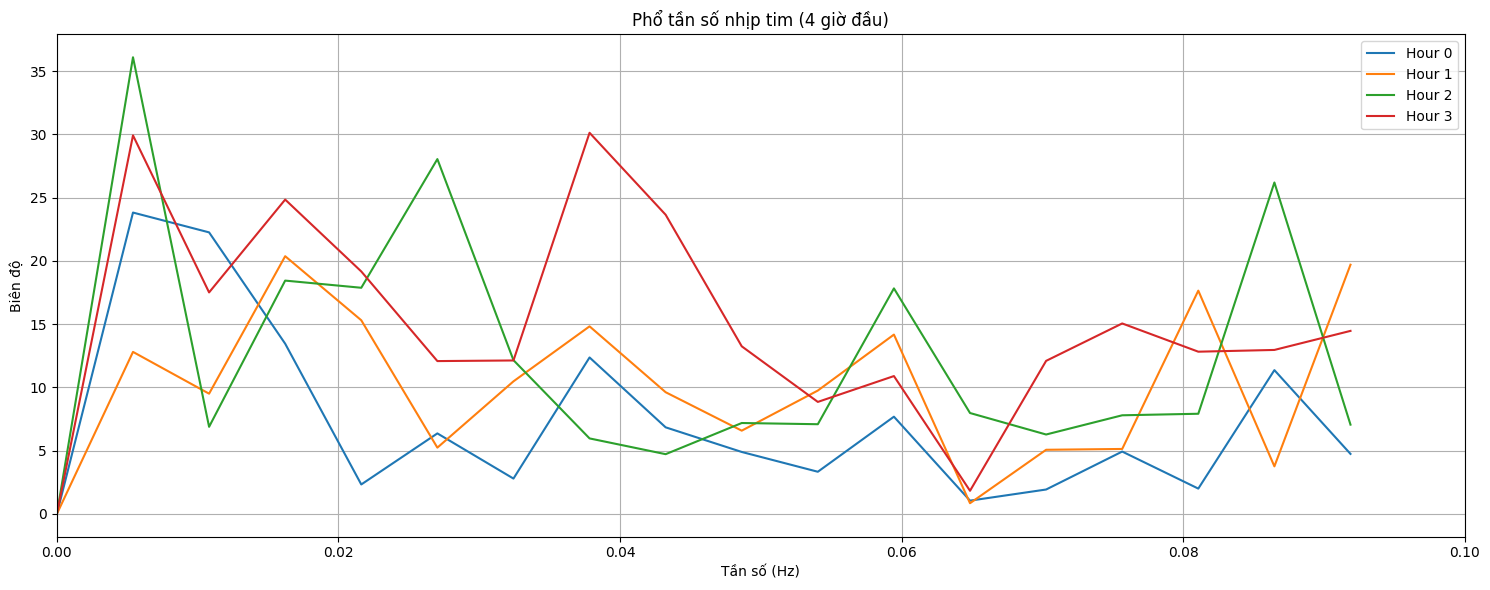

In [22]:
 #4. Vẽ phổ tần số 4 giờ đầu
plt.figure(figsize=(15, 6))
for i in range(4):
    plt.plot(spectra[i][0], spectra[i][1], label=f"Hour {i}")
plt.title("Phổ tần số nhịp tim (4 giờ đầu)")
plt.xlabel("Tần số (Hz)")
plt.ylabel("Biên độ")
plt.legend()
plt.grid(True)
plt.xlim(0, 0.1)
plt.tight_layout()
plt.show()

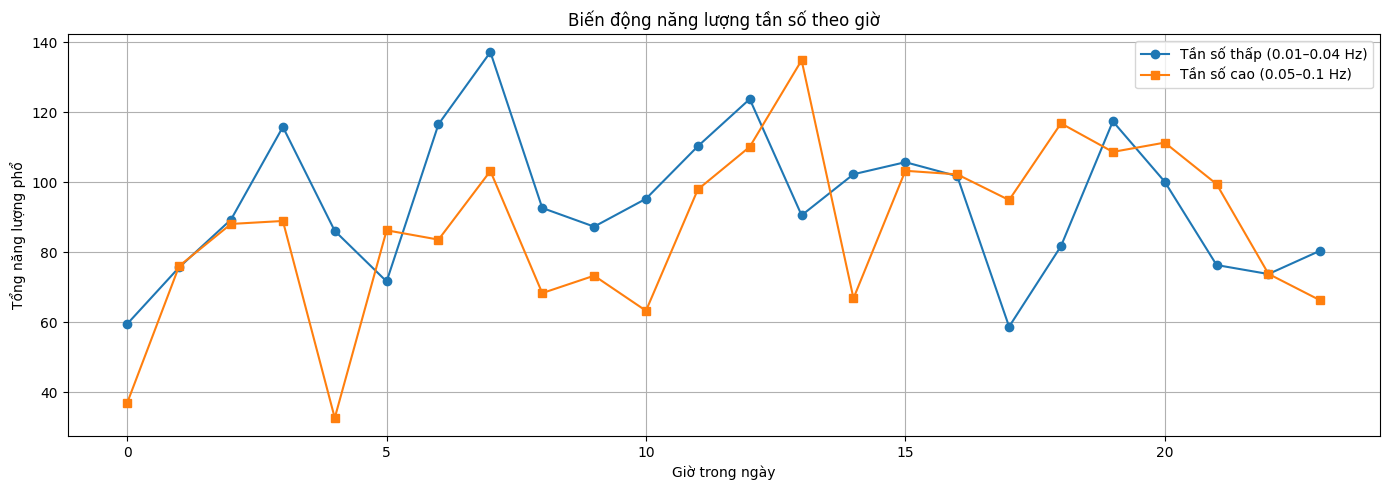

In [24]:
# 5. Phân tích năng lượng trong các dải tần số
low_freq_band = (0.01, 0.04)
high_freq_band = (0.05, 0.1)
low_freq_powers = []
high_freq_powers = []

for xf, yf in spectra:
    low_power = np.sum(yf[(xf >= low_freq_band[0]) & (xf <= low_freq_band[1])])
    high_power = np.sum(yf[(xf >= high_freq_band[0]) & (xf <= high_freq_band[1])])
    low_freq_powers.append(low_power)
    high_freq_powers.append(high_power)

# 6. Vẽ năng lượng tần số theo giờ
hours = np.arange(24)
plt.figure(figsize=(14, 5))
plt.plot(hours, low_freq_powers, label="Tần số thấp (0.01–0.04 Hz)", marker="o")
plt.plot(hours, high_freq_powers, label="Tần số cao (0.05–0.1 Hz)", marker="s")
plt.title("Biến động năng lượng tần số theo giờ")
plt.xlabel("Giờ trong ngày")
plt.ylabel("Tổng năng lượng phổ")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
